Amitav Mitra, Dowlette Alam El Din

## Calcium Imaging Analysis Code

In [439]:
import time
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
from collections import OrderedDict
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import HTML, display
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [440]:
# make figures appear large 
plt.rcParams['figure.figsize'] = [20, 5]

Just stuff for interactive displays. Run this next cell **BEFORE** running the following code

In [441]:
input_form = """
<div style="border:solid navy; padding:20px;">
<input type="file" id="file_selector" name="files[]"/>
<output id="list"></output>
</div>
"""

javascript = """
<script type="text/Javascript">
  function handleFileSelect(evt) {
    var kernel = IPython.notebook.kernel;
    var files = evt.target.files; // FileList object
    console.log('Executing orig')
    console.log(files)
    // files is a FileList of File objects. List some properties.
    var output = [];
    var f = files[0]
    output.push('<li><strong>', escape(f.name), '</strong> (', f.type || 'n/a', ') - ',
                  f.size, ' bytes, last modified: ',
                  f.lastModifiedDate ? f.lastModifiedDate.toLocaleDateString() : 'n/a',
                  '</_Mli>');
    document.getElementById('list').innerHTML = '<ul>' + output.join('') + '</ul>';
    var command = 'fname = "' + f.name + '"'
    console.log(command)
    kernel.execute(command);
  }

  document.getElementById('file_selector').addEventListener('change', handleFileSelect, false);
</script>
"""

def file_selector():
    display(HTML(input_form + javascript))

#########################################################################################################
sheetName = 'SELECT SHEET'
sheetSelector = widgets.Dropdown(options=[],description='Sheet name: ',disabled=False)
df = None # will be updated in handler call
def dropdown_handler(change):
    global sheetName
    global df
    global fname
    sheetName = change.new
    # automatically create dataframe with selection, update global
    df = pd.read_excel(io=fname,sheet_name=sheetName)
    # update master dict
    analyzerDict.update({sheetName:{}})
    
def sheet_selector(sheetnames):
    sheetSelector.options = sheetnames
    sheetSelector.observe(dropdown_handler, names='value')
    display(sheetSelector)
    
#########################################################################################################
frameName = 'Unnamed: 1'
dataName = 'Unnamed: 7'

frameSelector = widgets.Dropdown(options=[], description='Frames:',disabled=False)
dataSelector = widgets.Dropdown(options=[], description='Data:',disabled=False)

def frame_handler(change):
    global frameName
    frameName = change.new
def data_handler(change):
    global dataName
    dataName = change.new
    
def frame_selector(colnames):
    frameSelector.options=colnames
    frameSelector.observe(frame_handler,names='value')
    display(frameSelector)
    
def data_selector(colnames):
    dataSelector.options=colnames
    dataSelector.observe(data_handler,names='value')
    display(dataSelector)

**Helper functions for analysis and interactive, realtime plotting.**

This cell **MUST** be run once before continuing

In [442]:
def deltaFoverF(xs, ys):
    '''Gets the deltaF/F info
    Arguments:
    ----------
    xs : pandas.core.series.Series
        column from the dataframe representing frames
    ys : pandas.core.series.Series
        column from the dataframe containing data

    Returns:
    --------
    Fmin : float
        minimum value of fluorescence in ys
    xs : ndarray
        fixed array of frames, of same length as deltaF
    deltaF : ndarray
        numpy array with deltaF/F data from ys
    idx : ndarray
        boolean array with indices of valid (non-NaN) data
        in xs and ys
    '''
    validRange = xs.count()
    xs = xs[:validRange].to_numpy()
    ys = ys[:validRange].to_numpy()
    Fmin = np.min(ys)
    if Fmin == 0.0: print("WARNING - Fmin is zero")
    deltaF = np.fromiter(((i-Fmin)/Fmin for i in ys),float)
    idx = np.isfinite(xs) & np.isfinite(deltaF)
    return Fmin, xs[idx], deltaF[idx], idx

peaks = []
prominences = []
contour_heights = []
results_half = []
results_full = []
amplitudes = []

def update(h=0.2, w=5, wl=500):
    global peaks
    global prominences
    global contour_heights
    global results_half
    global results_full
    global amplitudes
    peaks, _ = find_peaks(deltaF[idx], height=h, width=w)
    prominences = peak_prominences(deltaF[idx], peaks, wlen=wl)
    contour_heights = deltaF[peaks] - prominences
    results_half = peak_widths(deltaF, peaks, prominence_data=prominences, rel_height=0.5)
    results_full = peak_widths(deltaF, peaks, prominence_data=prominences, rel_height=1)
    ax.clear()
    ax.plot(xs,deltaF)
    ax.plot(peaks,deltaF[peaks],'x')
    ax.vlines(x=peaks, ymin=contour_heights[0], ymax=deltaF[peaks], colors='red')
    amplitudes = deltaF[peaks] - contour_heights[0]
    ax.hlines(*results_half[1:], color="C2")
    ax.hlines(*results_full[1:], color="C3")
    ax.plot(np.zeros_like(xs), "--", color="gray")
    # update the master dict
    analyzerDict[sheetName]['peaks'] = peaks
    analyzerDict[sheetName]['results_full'] = results_full
    analyzerDict[sheetName]['amplitudes'] = amplitudes
    # let the user know that the information has been updated
    print('Saving calcium imaging information for sheet {}'.format(sheetName),end='\r')
    time.sleep(0.3)
    print('',end='\r')
    
def AvgRiseDecayTime(pks, res_full):
    '''Calculates rise and decay time for all peaks and returns average'''
    if (len(pks)==0): return np.nan, np.nan, np.nan, np.nan
    nPeaks = len(pks)
    totalRise = 0
    totalDecay = 0
    rises = []
    decays = []
    for pk in range(len(pks)):
        totalRise += pks[pk] - res_full[2][pk]
        rises.append(pks[pk] - res_full[2][pk])
        totalDecay += res_full[3][pk] - pks[pk]
        decays.append(res_full[3][pk] - pks[pk])
    avgRise = totalRise / nPeaks
    stdRise = np.std(rises)
    avgDecay = totalDecay / nPeaks
    stdDecay = np.std(decays)
    return avgRise, stdRise, avgDecay, stdDecay

def AvgPeakAmplitude(amplitudes):
    '''Returns average and std.dev of peak heights'''
    return np.average(amplitudes), np.std(amplitudes)

def AvgBurstDuration(res_full):
    '''Returns average burst duration and std.dev. of burst durations'''
    return np.average(res_full[0]), np.std(res_full[0])

def AvgISI(pks, tol=0.2):
    '''Calculates average time b/w spikes and std.dev.
    tol (float): time (percent of total duration) after which to ignore next spike
    '''
    if (len(peaks)==0): return np.nan, np.nan
    if (len(peaks)==1): return np.nan, np.nan
    nSpikePairs = len(pks)-1 # subtract 1 because number of PAIRS of peaks = number of peaks-1
    if nSpikePairs==0:
        return np.nan, np.nan
    totalTimeDiff = 0
    diffs = []
    for pk in range(1,len(pks)):
        #print(pks[pk] - pks[pk-1])
        if (pks[pk] - pks[pk-1]) > (tol * xs[-1]):
            continue
        else:
            totalTimeDiff += pks[pk]-pks[pk-1]
            diffs.append(pks[pk]-pks[pk-1])
            
    avgISI = totalTimeDiff/nSpikePairs
    stdISI = np.std(diffs)
    
    return avgISI, stdISI

def AvgIBI(pks, res_full, tol=0.2):
    '''Calculates average time between bursts and std.dev'''
    if (len(peaks)==0): return np.nan, np.nan
    # Iterate over spikes (they may be peaks)
    spikeTimes = []     # store the times of spikes within burst
    avgBurstTimes = []  # store the avg of the burst 
    for pk in range(1, len(pks)):
        #print(pks[pk] - pks[pk-1])
        if (pks[pk] - pks[pk-1]) > (tol * xs[-1]): # We've now reached a new burst, according to our tolerance
            if len(spikeTimes) == 1: # Then there's only one burst (no spikes)
                avgBurstTimes.append(spikeTimes[0])
            else:
                avgBurstTimes.append(np.average(spikeTimes))
        else:
            spikeTimes.append(pks[pk])
    avgIBI = np.average(avgBurstTimes)
    stdIBI = np.std(avgBurstTimes)
    return avgIBI, stdIBI            

def FiringRate(pks):
    '''Calculates the number of peaks per second for given dataset'''
    secPerFrame = 0.08
    duration_frames = xs[-1]
    duration_seconds = duration_frames * secPerFrame
    if (duration_seconds==0.0): return np.nan
    peaksPerSecond = len(pks)/duration_seconds
    # if xs is given in seconds, you'd delete everything else and just return:
    #return len(pks)/xs[-1]
    return peaksPerSecond

def TotalNormalizedActivationTime(res_full):
    '''Calculates the total time activated (burst durations) divided by total acquisition time'''
    totalActiveTime = np.sum(res_full[0])
    duration_frames = xs[-1]
    if (duration_frames==0.0): return np.nan
    return totalActiveTime/duration_frames

analyzerDict = {}
def analyze(ISI_tol=0.2,IBI_tol=0.2):
    global analyzerDict
    print('Saving results from file {}'.format(fname))
    data = []
    for sheetname, analysisDict in analyzerDict.items():
        sheetData = []
        if len(analysisDict) == 0:
            continue
        sheetData.append(sheetname)
        # Run statistical analyses, append every result to sheetData
        avgRise, stdRise, avgDecay, stdDecay = AvgRiseDecayTime(analyzerDict[sheetname]['peaks'], analyzerDict[sheetname]['results_full'])
        sheetData.append(avgRise)             # Average rise times
        sheetData.append(stdRise)             # Std Dev rise times
        sheetData.append(avgDecay)            # Average decay times
        sheetData.append(stdDecay)            # Std Dev decay times
        avgPeakAmp, stdPeakAmp = AvgPeakAmplitude(analyzerDict[sheetname]['amplitudes'])
        sheetData.append(avgPeakAmp)          # Average peak amplitude
        sheetData.append(stdPeakAmp)          # Std dev peak amps
        avgBurstDuration, stdBurstDuration = AvgBurstDuration(analyzerDict[sheetname]['results_full'])
        sheetData.append(avgBurstDuration)    # Average burst duration
        sheetData.append(stdBurstDuration)    # Std Dev burst duration
        avgISI, stdISI = AvgISI(analyzerDict[sheetname]['peaks'], tol=ISI_tol)
        sheetData.append(avgISI)              # Average ISI (actually avg time b/w spikes)
        sheetData.append(stdISI)              # Std Dev ISI (actually std dev of time b/w spikes)
        avgIBI, stdIBI = AvgIBI(analyzerDict[sheetname]['peaks'], analyzerDict[sheetname]['results_full'], tol=IBI_tol)
        sheetData.append(avgIBI)              # Average IBI (IGNORE THIS)
        sheetData.append(stdIBI)              # Std Dev IBI (IGNORE THIS)
        firingRate = FiringRate(analyzerDict[sheetname]['peaks'])
        sheetData.append(firingRate)          # Firing rate
        nPeaks = len(analyzerDict[sheetname]['amplitudes'])
        sheetData.append(nPeaks)              # Number of peaks
        # add it to the final data for all sheets
        data.append(sheetData)
    # Create output dataframe
    outDF = pd.DataFrame(data, columns=[
        'SheetName','AvgRiseTimes','StdDevRiseTimes','AvgDecayTimes','StdDevDecayTimes',
        'AvgPeakAmp','StdDevPeakAmp','AvgBurstDuration','StdDevBurstDuration',
        'AvgTimeBtwSpikes','StdDevTimeBtwSpikes','AvgIBI','StdDevIBI','FiringRate','nPeaks'])
    outDF.to_csv('OUTPUT_{}.csv'.format(fname.split('.')[0]), encoding='utf-8-sig', index=False)
    # Reset the analyzer dictionary
    analyzerDict = {}

# --------------------------------------------------------------
# MAIN ANALYSIS CODE
# --------------------------------------------------------------

**Open file to analyze.** 

Run the cell, then use the button to select a file. Once the cell has been run, it does not need to be re-run to select a new file.

In [443]:
file_selector()

**Run this next cell to get a `{sheetname : dataframe}` dictionary and display a dropdown for selecting the sheet you want to study.**

This cell **MUST BE** re-run every time you open a new file, but **not** if you just want to choose a new sheet to analyze.

In [444]:
xl = pd.ExcelFile(fname)
sheetDict = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}
sheet_selector(list(sheetDict.keys()))

Dropdown(description='Sheet name: ', options=('W10_1', 'W10_2', 'W10_3', 'W12_1', 'W12_2', 'W12_3', 'W12_4', '…

**Run this next cell to get a dropdown list of the available columns to analyze.**

If you changed the file, you **will** have to re-run this cell. Otherwise, you can just use the dropdown to select new frame/data columns if you're analyzing the same sheet.

In [447]:
frame_selector(df.keys().to_list())
data_selector(df.keys().to_list())

Dropdown(description='Frames:', options=('Unnamed: 0', 'Frames', 'ROI 1', 'ROI 2', 'ROI 3', 'ROI 4', 'ROI 5', …

Dropdown(description='Data:', options=('Unnamed: 0', 'Frames', 'ROI 1', 'ROI 2', 'ROI 3', 'ROI 4', 'ROI 5', 'W…

## Run the following cell once to begin interactive plotting, after selecting file + sheet + frame + data

<IPython.core.display.Javascript object>


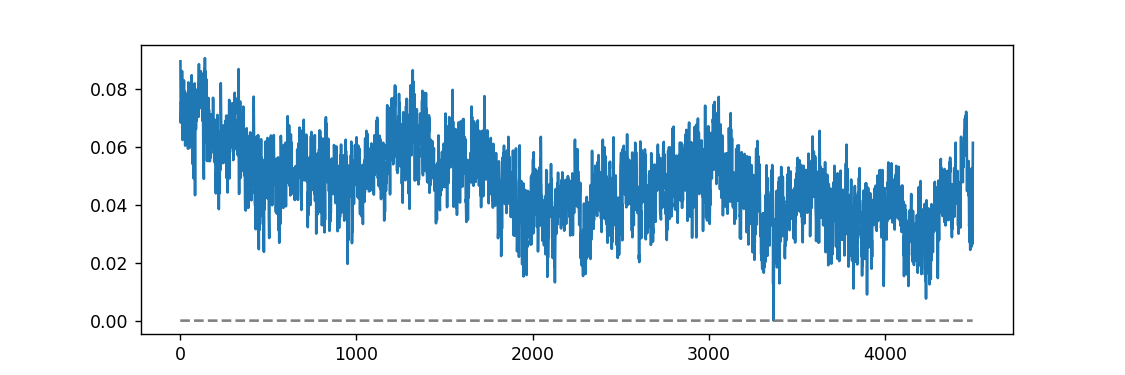

interactive(children=(FloatSlider(value=0.2, description='h', max=1.0, min=0.01, step=0.01), FloatSlider(value…

In [462]:
%matplotlib notebook
plt.ion() # enable matplotlib interactive
Fmin, xs, deltaF, idx = deltaFoverF(df[frameName],df[dataName])
fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(1,1,1)
interact(update,
         h=widgets.FloatSlider(value=0.2,min=0.01,max=1.0,step=0.01),
         w=widgets.FloatSlider(value=5,min=1,max=100,step=1),
         wl=widgets.FloatSlider(value=100,min=2,max=1800,step=1));

## Run the next cell once you have finished analyzing all selected sheets in the file

It will produce an output CSV file. 

**WARNING: do not run this cell until you've analyzed all of the sheets in the file that you want. Once you run the next cell, the information will be saved to an Excel file and the global dictionary storing it will be lost.**

**Known issues and to-do:**
* IBI and ISI calculations need some more thought
* Operation could be streamlined
* need to double-check that outputs make sense
* pickle the dictionary storing the information so that it can be recovered in the event of an accidental `analyze()` call

In [463]:
analyze()

Saving results from file LD Calcium Imaging Time Course.xlsx


C:\Users\dalam\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\dalam\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\dalam\anaconda3\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dalam\anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dalam\anaconda3\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**To see the sheets whose information you've already analyzed, run the next cell. It will print the internal dictionary of the sheetnames and their respective analyzed data.**

In [345]:
analyzerDict = analyzerDictTemporary.copy()

In [346]:
analyzerDict

{'W2_2': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W2_3': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W2_4': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W2_5': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W4_1': {'peaks': array([ 820, 1970, 2914, 3637, 4257], dtype=int64),
  'results_full': (array([406.72136752, 431.9415011 ,

In [337]:
analyzerDict 
#analyzerDictTemporary = analyzerDict
#analyzerDictTemporary

{'W2_2': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W2_3': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W2_4': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W2_5': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W4_1': {'peaks': array([ 820, 1970, 2914, 3637, 4257], dtype=int64),
  'results_full': (array([406.72136752, 431.9415011 ,

# outputted data 

In [338]:
analyzerDictTemporary

{'W2_2': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W2_3': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W2_4': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W2_5': {'peaks': array([], dtype=int64),
  'results_full': (array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)),
  'amplitudes': array([], dtype=float64)},
 'W4_1': {'peaks': array([ 820, 1970, 2914, 3637, 4257], dtype=int64),
  'results_full': (array([406.72136752, 431.9415011 ,

**Peak Information:**
* `peaks` - numpy array, stores time (frame) of peak
* `len(peaks)` - number of peaks

In [ ]:
peaks

In [ ]:
len(peaks)

**Peak height and width info:**
* `results_full`
* `results_half`

Both are the peak width and height information for the peaks @ full and half width, respectively. 

* `widths` : ndarray
    * The widths for each peak in samples.
* `width_heights` : ndarray
    * The height of the contour lines at which the `widths` where evaluated.
    * **NOTE:** this is *not* the height of the peak - this is how high above zero the *width* evaluation is
* `left_ips`, `right_ips` : ndarray
    * Interpolated positions of left and right intersection points of a horizontal line at the respective evaluation height.

Here is the full tuple of information:

In [ ]:
results_full

The first element is the width of each peak (in frames):

In [ ]:
results_full[0]

The second element is the width heights (in $\Delta F/F$):

In [ ]:
results_full[1]

The 3rd and 4th elements of `results_full` and `results_half` are the left and right ends, respectively, of the peak width. 

To show how this all works, let's look at peaks 1 and 2:

In [ ]:
def peakInfo(peakNumber):
    assert(peakNumber < len(peaks))
    peakLoc = peaks[peakNumber-1]
    peakWidth = results_full[0][peakNumber-1]
    peakHeight = results_full[1][peakNumber-1]
    peakStart = results_full[2][peakNumber-1]
    peakEnd = results_full[3][peakNumber-1]
    print('Peak #{}\n\t is located at frame {},\n\t has width of {} frames,\n\t height of {},\n\t and starts and ends at frames ({},{})'.format(peakNumber,peakLoc,peakWidth,peakHeight,peakStart,peakEnd))
    print('check: peakEnd-peakStart\n\t = {}-{}\n\t = {}'.format(peakEnd,peakStart,peakEnd-peakStart))
    assert(peakWidth==peakEnd-peakStart)

In [ ]:
for i in range(0,len(peaks)):
    peakInfo(i)

# MATPLOTLIB INTERACTIVITY TEST

In [ ]:
%matplotlib notebook

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw_idle()

interact(update, w=widgets.FloatSlider(min=0.01,max=10.0,step=0.01),);